# Non-Adversarial Generative Model: VQ-VAE + Transformer
## **Authors**: Ryan Waldman and Reid Layne
## Project OverviewComplete implementation of VQ-VAE + Transformer for CIFAR-10 image generation without adversarial training.

## 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm
import os

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Configuration

In [2]:
# VQ-VAE Config
NUM_EMBEDDINGS = 512
EMBEDDING_DIM = 64
COMMITMENT_COST = 0.25
HIDDEN_CHANNELS = 128

# Dimensions
IMAGE_SIZE = 32
IMAGE_CHANNELS = 3
LATENT_H = 8
LATENT_W = 8
SEQ_LEN = 64

# Training
VQVAE_BATCH_SIZE = 128
VQVAE_EPOCHS = 30
VQVAE_LR = 3e-4

# Transformer Config
D_MODEL = 256
N_HEADS = 4
N_LAYERS = 4
DROPOUT = 0.1
TRANSFORMER_BATCH_SIZE = 64
TRANSFORMER_EPOCHS = 30
TRANSFORMER_LR = 3e-4

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('plots', exist_ok=True)

## 3. Load CIFAR-10

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=VQVAE_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VQVAE_BATCH_SIZE, shuffle=False, num_workers=2)
print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Train: 50000, Test: 10000


## 4. VQ-VAE Architecture

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.embeddings.weight, -1.0/num_embeddings, 1.0/num_embeddings)

    def forward(self, inputs):
        B, C, H, W = inputs.shape
        flat_input = inputs.permute(0, 2, 3, 1).contiguous().view(-1, self.embedding_dim)

        distances = (
            torch.sum(flat_input ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(flat_input, self.embeddings.weight.t())
        )

        encoding_indices = torch.argmin(distances, dim=1)
        encoding_indices_reshaped = encoding_indices.view(B, H, W)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices.unsqueeze(1), 1)

        quantized = torch.matmul(encodings, self.embeddings.weight).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()

        codebook_loss = F.mse_loss(quantized, inputs.detach())
        commitment_loss = F.mse_loss(quantized.detach(), inputs)
        vq_loss = codebook_loss + self.commitment_cost * commitment_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()

        return quantized, vq_loss, encoding_indices_reshaped

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=128, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, latent_dim, 3, stride=1, padding=1)
        )
    def forward(self, x):
        return self.net(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, hidden_channels=128, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_channels, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, 4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hidden_channels, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

In [7]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64, commitment_cost=0.25, hidden_channels=128, in_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_channels, embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(in_channels, hidden_channels, embedding_dim)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, _ = self.vq(z)
        x_recon = self.decoder(quantized)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        return x_recon, loss, recon_loss, vq_loss

    def encode_to_indices(self, x):
        z = self.encoder(x)
        _, _, indices = self.vq(z)
        return indices

    def decode_from_indices(self, indices):
        B, H, W = indices.shape
        indices_flat = indices.view(-1)
        quantized_flat = self.vq.embeddings(indices_flat)
        quantized = quantized_flat.view(B, H, W, self.embedding_dim).permute(0, 3, 1, 2).contiguous()
        images = self.decoder(quantized)
        return images
print('VQ-VAE classes defined')

VQ-VAE classes defined


## 5. Train VQ-VAE

In [8]:
vqvae = VQVAE(NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST, HIDDEN_CHANNELS, IMAGE_CHANNELS).to(device)
optimizer = optim.Adam(vqvae.parameters(), lr=VQVAE_LR)
vqvae_train_losses = []
vqvae_recon_losses = []
vqvae_vq_losses = []
print('Starting VQ-VAE training...')
vqvae.train()
for epoch in range(VQVAE_EPOCHS):
    epoch_loss = epoch_recon = epoch_vq = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{VQVAE_EPOCHS}')

    for images, _ in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        recon, total_loss, recon_loss, vq_loss = vqvae(images)
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        epoch_recon += recon_loss.item()
        epoch_vq += vq_loss.item()
        pbar.set_postfix({'loss': f'{total_loss.item():.4f}'})

    avg_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_vq = epoch_vq / len(train_loader)

    vqvae_train_losses.append(avg_loss)
    vqvae_recon_losses.append(avg_recon)
    vqvae_vq_losses.append(avg_vq)

    print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, Recon={avg_recon:.4f}, VQ={avg_vq:.4f}')

    if (epoch + 1) % 5 == 0:
        torch.save(vqvae.state_dict(), f'checkpoints/vqvae_epoch{epoch+1}.pth')
torch.save(vqvae.state_dict(), 'checkpoints/vqvae_final.pth')
print('VQ-VAE training complete!')

Starting VQ-VAE training...


Epoch 1/30: 100%|██████████| 391/391 [00:18<00:00, 20.64it/s, loss=4.0715]


Epoch 1: Loss=15.2276, Recon=0.1211, VQ=15.1066


Epoch 2/30: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s, loss=1.4697]


Epoch 2: Loss=2.7821, Recon=0.0783, VQ=2.7038


Epoch 3/30: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s, loss=0.3968]


Epoch 3: Loss=0.7731, Recon=0.0623, VQ=0.7108


Epoch 4/30: 100%|██████████| 391/391 [00:17<00:00, 22.67it/s, loss=0.2018]


Epoch 4: Loss=0.2908, Recon=0.0521, VQ=0.2386


Epoch 5/30: 100%|██████████| 391/391 [00:17<00:00, 22.11it/s, loss=0.1338]


Epoch 5: Loss=0.1729, Recon=0.0446, VQ=0.1283


Epoch 6/30: 100%|██████████| 391/391 [00:17<00:00, 22.59it/s, loss=0.1020]


Epoch 6: Loss=0.1212, Recon=0.0395, VQ=0.0817


Epoch 7/30: 100%|██████████| 391/391 [00:17<00:00, 22.57it/s, loss=0.0914]


Epoch 7: Loss=0.1001, Recon=0.0356, VQ=0.0645


Epoch 8/30: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s, loss=0.0812]


Epoch 8: Loss=0.0853, Recon=0.0324, VQ=0.0528


Epoch 9/30: 100%|██████████| 391/391 [00:16<00:00, 23.35it/s, loss=0.0671]


Epoch 9: Loss=0.0745, Recon=0.0296, VQ=0.0449


Epoch 10/30: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s, loss=0.0628]


Epoch 10: Loss=0.0676, Recon=0.0272, VQ=0.0404


Epoch 11/30: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s, loss=0.0631]


Epoch 11: Loss=0.0651, Recon=0.0256, VQ=0.0395


Epoch 12/30: 100%|██████████| 391/391 [00:16<00:00, 23.26it/s, loss=0.0637]


Epoch 12: Loss=0.0637, Recon=0.0244, VQ=0.0393


Epoch 13/30: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s, loss=0.0624]


Epoch 13: Loss=0.0627, Recon=0.0234, VQ=0.0393


Epoch 14/30: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s, loss=0.0587]


Epoch 14: Loss=0.0628, Recon=0.0226, VQ=0.0402


Epoch 15/30: 100%|██████████| 391/391 [00:16<00:00, 23.22it/s, loss=0.0643]


Epoch 15: Loss=0.0647, Recon=0.0221, VQ=0.0426


Epoch 16/30: 100%|██████████| 391/391 [00:16<00:00, 23.41it/s, loss=0.0661]


Epoch 16: Loss=0.0669, Recon=0.0215, VQ=0.0454


Epoch 17/30: 100%|██████████| 391/391 [00:17<00:00, 22.26it/s, loss=0.0618]


Epoch 17: Loss=0.0682, Recon=0.0211, VQ=0.0471


Epoch 18/30: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s, loss=0.0700]


Epoch 18: Loss=0.0685, Recon=0.0207, VQ=0.0479


Epoch 19/30: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s, loss=0.0718]


Epoch 19: Loss=0.0683, Recon=0.0203, VQ=0.0480


Epoch 20/30: 100%|██████████| 391/391 [00:17<00:00, 22.83it/s, loss=0.0705]


Epoch 20: Loss=0.0680, Recon=0.0200, VQ=0.0480


Epoch 21/30: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s, loss=0.0675]


Epoch 21: Loss=0.0675, Recon=0.0197, VQ=0.0478


Epoch 22/30: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s, loss=0.0683]


Epoch 22: Loss=0.0671, Recon=0.0195, VQ=0.0476


Epoch 23/30: 100%|██████████| 391/391 [00:16<00:00, 23.29it/s, loss=0.0733]


Epoch 23: Loss=0.0668, Recon=0.0193, VQ=0.0475


Epoch 24/30: 100%|██████████| 391/391 [00:17<00:00, 22.48it/s, loss=0.0671]


Epoch 24: Loss=0.0667, Recon=0.0191, VQ=0.0476


Epoch 25/30: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s, loss=0.0667]


Epoch 25: Loss=0.0667, Recon=0.0189, VQ=0.0478


Epoch 26/30: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s, loss=0.0647]


Epoch 26: Loss=0.0666, Recon=0.0188, VQ=0.0479


Epoch 27/30: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s, loss=0.0690]


Epoch 27: Loss=0.0667, Recon=0.0186, VQ=0.0481


Epoch 28/30: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s, loss=0.0716]


Epoch 28: Loss=0.0668, Recon=0.0185, VQ=0.0483


Epoch 29/30: 100%|██████████| 391/391 [00:16<00:00, 23.38it/s, loss=0.0669]


Epoch 29: Loss=0.0670, Recon=0.0184, VQ=0.0486


Epoch 30/30: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s, loss=0.0696]

Epoch 30: Loss=0.0672, Recon=0.0183, VQ=0.0490
VQ-VAE training complete!


## 6. Visualize Reconstructions

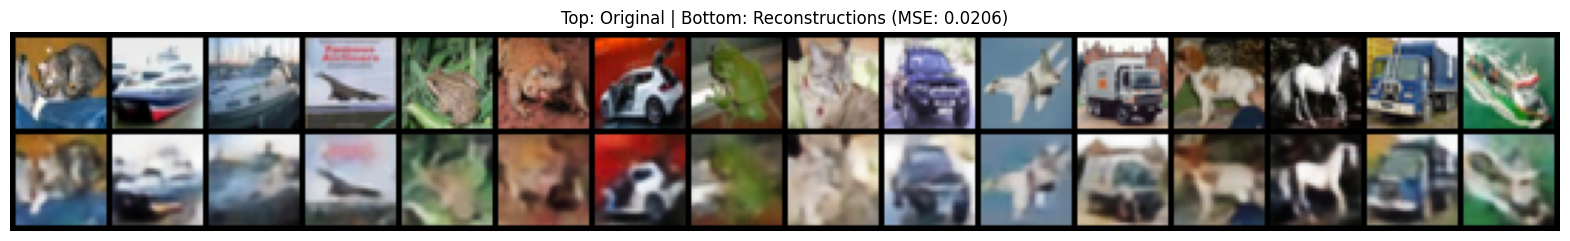

Reconstruction MSE: 0.020604


In [9]:
vqvae.eval()
with torch.no_grad():
    test_iter = iter(test_loader)
    test_images, _ = next(test_iter)
    test_images = test_images[:16].to(device)
    recon_images, _, recon_loss, _ = vqvae(test_images)

    comparison = torch.cat([test_images.cpu(), recon_images.cpu()])
    grid = vutils.make_grid(comparison, nrow=16, padding=2, normalize=True)

    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(f'Top: Original | Bottom: Reconstructions (MSE: {recon_loss.item():.4f})')
    plt.axis('off')
    plt.savefig('outputs/vqvae_reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Reconstruction MSE: {recon_loss.item():.6f}')

## 7. Extract Tokens

In [10]:
print('Extracting tokens from training set...')
all_tokens = []
vqvae.eval()
with torch.no_grad():
    for images, _ in tqdm(train_loader, desc='Encoding'):
        images = images.to(device)
        indices = vqvae.encode_to_indices(images)
        all_tokens.append(indices.cpu())
all_tokens = torch.cat(all_tokens, dim=0)
all_tokens_flat = all_tokens.view(all_tokens.size(0), -1)
np.save('outputs/cifar10_tokens.npy', all_tokens_flat.numpy())
print(f'Saved {all_tokens_flat.shape[0]} token sequences to outputs/cifar10_tokens.npy')

Extracting tokens from training set...


Encoding: 100%|██████████| 391/391 [00:11<00:00, 33.16it/s]

Saved 50000 token sequences to outputs/cifar10_tokens.npy


## 8. Token Dataset

In [11]:
class TokenDataset(Dataset):
    def __init__(self, token_file):
        self.tokens = np.load(token_file)
        print(f'Loaded {len(self.tokens)} sequences from {token_file}')

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        seq = self.tokens[idx]
        x = torch.tensor(seq[:-1], dtype=torch.long)
        y = torch.tensor(seq[1:], dtype=torch.long)
        return x, y
token_dataset = TokenDataset('outputs/cifar10_tokens.npy')

Loaded 50000 sequences from outputs/cifar10_tokens.npy


## 9. Transformer Architecture

In [12]:
@dataclass
class TransformerConfig:
    vocab_size: int = 512
    seq_len: int = 63
    d_model: int = 256
    n_heads: int = 4
    n_layers: int = 4
    dropout: float = 0.1
config = TransformerConfig(NUM_EMBEDDINGS, SEQ_LEN-1, D_MODEL, N_HEADS, N_LAYERS, DROPOUT)

In [13]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_model = config.d_model
        self.n_heads = config.n_heads
        self.head_dim = config.d_model // config.n_heads
        self.qkv_proj = nn.Linear(config.d_model, 3 * config.d_model)
        self.out_proj = nn.Linear(config.d_model, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        B, L, d_model = x.shape
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, L, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, L, d_model)
        return self.out_proj(out)

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = SelfAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, 4 * config.d_model),
            nn.GELU(),
            nn.Linear(4 * config.d_model, config.d_model),
            nn.Dropout(config.dropout)
        )
    def forward(self, x, mask=None):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.ffn(self.ln2(x))
        return x

In [15]:
class GPTSmall(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Embedding(config.seq_len, config.d_model)
        self.dropout = nn.Dropout(config.dropout)
        self.blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layers)])
        self.ln_f = nn.LayerNorm(config.d_model)
        self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        B, L = x.shape
        positions = torch.arange(0, L, device=x.device).unsqueeze(0)
        tok_emb = self.token_emb(x)
        pos_emb = self.pos_emb(positions)
        h = self.dropout(tok_emb + pos_emb)
        mask = torch.triu(torch.ones(L, L, device=x.device), diagonal=1).bool()

        for block in self.blocks:
            h = block(h, mask)

        h = self.ln_f(h)
        logits = self.head(h)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, start_tokens, max_new_tokens, temperature=1.0, top_k=None):
        self.eval()
        x = start_tokens
        for _ in range(max_new_tokens):
            B, L = x.shape
            x_cond = x[:, -self.config.seq_len:] if L > self.config.seq_len else x
            logits, _ = self(x_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            x = torch.cat([x, next_token], dim=1)
        return x
print('Transformer classes defined')

Transformer classes defined


## 10. Train Transformer

In [ ]:
token_loader = DataLoader(token_dataset, batch_size=TRANSFORMER_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
transformer = GPTSmall(config).to(device)
optimizer_transformer = optim.AdamW(transformer.parameters(), lr=TRANSFORMER_LR, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_transformer, T_max=TRANSFORMER_EPOCHS)
transformer_train_losses = []
print('Starting Transformer training...')
transformer.train()
for epoch in range(TRANSFORMER_EPOCHS):
    epoch_loss = 0.0
    pbar = tqdm(token_loader, desc=f'Epoch {epoch+1}/{TRANSFORMER_EPOCHS}')

    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer_transformer.zero_grad()
        logits, loss = transformer(x, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        optimizer_transformer.step()
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    scheduler.step()
    avg_loss = epoch_loss / len(token_loader)
    transformer_train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}: Loss={avg_loss:.4f}, LR={scheduler.get_last_lr()[0]:.6f}')

    if (epoch + 1) % 5 == 0:
        torch.save(transformer.state_dict(), f'checkpoints/transformer_epoch{epoch+1}.pth')
torch.save(transformer.state_dict(), 'checkpoints/transformer_final.pth')
print('Transformer training complete!')

Starting Transformer training...


Epoch 1/30: 100%|██████████| 782/782 [00:27<00:00, 28.17it/s, loss=3.6250]


Epoch 1: Loss=3.8313, LR=0.000299


Epoch 2/30: 100%|██████████| 782/782 [00:27<00:00, 28.72it/s, loss=3.7397]


Epoch 2: Loss=3.6238, LR=0.000297


Epoch 3/30: 100%|██████████| 782/782 [00:26<00:00, 29.21it/s, loss=3.4877]


Epoch 3: Loss=3.5848, LR=0.000293


Epoch 4/30: 100%|██████████| 782/782 [00:26<00:00, 29.02it/s, loss=3.3099]


Epoch 4: Loss=3.5595, LR=0.000287


Epoch 5/30: 100%|██████████| 782/782 [00:27<00:00, 28.83it/s, loss=3.4258]


Epoch 5: Loss=3.5387, LR=0.000280


Epoch 6/30:  35%|███▍      | 270/782 [00:09<00:17, 28.52it/s, loss=3.4659]

## 11. Generate Images

In [ ]:
def generate_images(num_samples=64, temperature=1.0, top_k=100):
    transformer.eval()
    vqvae.eval()
    with torch.no_grad():
        start_tokens = torch.zeros((num_samples, 1), dtype=torch.long, device=device)
        token_sequences = transformer.generate(start_tokens, max_new_tokens=SEQ_LEN-1, temperature=temperature, top_k=top_k)
        token_sequences = token_sequences[:, -SEQ_LEN:]
        indices = token_sequences.view(num_samples, LATENT_H, LATENT_W)
        images = vqvae.decode_from_indices(indices)
    return images
print('Generating samples...')
generated_images = generate_images(num_samples=64)
print('Generation complete!')

## 12. Visualize Generated Samples

In [ ]:
# Display generated images
images_denorm = (generated_images.cpu() + 1) / 2.0
images_denorm = torch.clamp(images_denorm, 0, 1)
grid = vutils.make_grid(images_denorm, nrow=8, padding=2)
plt.figure(figsize=(16, 16))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.title('Generated Images from VQ-VAE + Transformer')
plt.axis('off')
plt.savefig('outputs/generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Plot Training Curves

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(vqvae_train_losses, linewidth=2, color='blue', label='Total')
axes[0].plot(vqvae_recon_losses, linewidth=2, color='green', linestyle='--', label='Recon')
axes[0].plot(vqvae_vq_losses, linewidth=2, color='red', linestyle=':', label='VQ')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('VQ-VAE Training', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(transformer_train_losses, linewidth=2, color='purple')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Cross-Entropy Loss', fontweight='bold')
axes[1].set_title('Transformer Training', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Results Summary

In [ ]:

print(f'\nVQ-VAE Final Loss: {vqvae_train_losses[-1]:.6f}')
print(f'Reconstruction Loss: {vqvae_recon_losses[-1]:.6f}')
print(f'VQ Loss: {vqvae_vq_losses[-1]:.6f}')
print(f'\nTransformer Final Loss: {transformer_train_losses[-1]:.6f}')
